In [1]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from autoencoder import Autoencoder
from solver import train_vali_all_epochs, dev_train_vali_all_epochs

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
run_id = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
save_path = os.getenv("HOME") + '/sparsify_models/AE/MNIST/' +run_id +'/'
print(save_path)

/home/david/sparsify_models/AE/MNIST/2024-11-08_10-05-23/


In [4]:
# Convert MNIST data to numpy arrays
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    train_images.append(input.cpu().numpy())
    train_labels.append(target.cpu().numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    test_images.append(input.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

### Linear Support Vector Classification
Objective: find the hyperplane that best separates the classes in the feature space.

In [5]:
svc = LinearSVC(max_iter=1000, C=1.0)
svc.fit(train_images, train_labels)

predictions = svc.predict(test_images)
accuracy = accuracy_score(test_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9183


### Training SAE and DAE

In [6]:
model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.99)

train_losses, vali_losses = train_vali_all_epochs(
    model, 
    train_loader, 
    test_loader, 
    optimizer, 
    n_epochs=10, 
    device=torch.device('cuda'), 
    save_path=save_path+'Static/'
    )

Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.000213: 100%|██████████| 469/469 [00:02<00:00, 165.09it/s]


====> Epoch: 0 Average loss: 0.0356


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:308: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True).to(device)


====> Test set loss: 0.0196
Directory created: /home/david/sparsify_models/AE/MNIST/2024-11-08_10-05-23/Static/
Weights saved.


Train Epoch: 1 [44928/60000 (100%)]	Loss: 0.000184: 100%|██████████| 469/469 [00:02<00:00, 188.70it/s]


====> Epoch: 1 Average loss: 0.0183
====> Test set loss: 0.0170
Weights saved.


Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.000186: 100%|██████████| 469/469 [00:02<00:00, 198.05it/s]

====> Epoch: 2 Average loss: 0.0174


====> Test set loss: 0.0169
Weights saved.


Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.000179: 100%|██████████| 469/469 [00:02<00:00, 221.58it/s]

====> Epoch: 3 Average loss: 0.0174


====> Test set loss: 0.0169
Weights saved.


Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.000193: 100%|██████████| 469/469 [00:01<00:00, 244.73it/s]


====> Epoch: 4 Average loss: 0.0174
====> Test set loss: 0.0169
Weights saved.


Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.000190: 100%|██████████| 469/469 [00:01<00:00, 242.33it/s]


====> Epoch: 5 Average loss: 0.0173
====> Test set loss: 0.0169
Weights saved.


Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.000164: 100%|██████████| 469/469 [00:02<00:00, 199.15it/s]

====> Epoch: 6 Average loss: 0.0173


====> Test set loss: 0.0169
Weights saved.


Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.000188: 100%|██████████| 469/469 [00:02<00:00, 230.40it/s]


====> Epoch: 7 Average loss: 0.0173
====> Test set loss: 0.0169
Weights saved.


Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.000183: 100%|██████████| 469/469 [00:01<00:00, 267.43it/s]

====> Epoch: 8 Average loss: 0.0173


====> Test set loss: 0.0169
Weights saved.


Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.000176: 100%|██████████| 469/469 [00:01<00:00, 241.15it/s]

====> Epoch: 9 Average loss: 0.0173


====> Test set loss: 0.0169
Weights saved.
All train losses saved.


In [7]:
dev_model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
dev_optimizer = torch.optim.SGD(dev_model.parameters(), lr=0.5, momentum=0.99)

size_ls = [4,10,16,32]
manner = 'cell_division'

dev_train_vali_all_epochs(
    dev_model,
    size_ls,
    manner,
    train_loader,
    test_loader,
    optimizer,
    n_epochs=10,
    device='cpu',
    save_path=save_path+'Dev/{}/'.format(manner)
    )

Directory created: /home/david/sparsify_models/AE/MNIST/2024-11-08_10-05-23/Dev/cell_division/


Train Epoch: 0 [44928/60000 (100%)]	Loss: 0.001272: 100%|██████████| 469/469 [00:03<00:00, 118.80it/s]

====> Epoch: 0 Average loss: 0.1255


====> Test set loss: 0.1278
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


/home/david/Documents/UNI_LOCAL/developing-autoencoders/solver.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path + 'model_weights_epoch

====> Epoch: 1 Average loss: 0.0610


====> Test set loss: 0.0492
Weights saved.
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.000531: 100%|██████████| 469/469 [00:05<00:00, 83.19it/s]

====> Epoch: 2 Average loss: 0.0491


====> Test set loss: 0.0482
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 3 [44928/60000 (100%)]	Loss: 0.000456: 100%|██████████| 469/469 [00:05<00:00, 89.94it/s] 


====> Epoch: 3 Average loss: 0.0474
====> Test set loss: 0.0447
Weights saved.
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 4 [44928/60000 (100%)]	Loss: 0.000436: 100%|██████████| 469/469 [00:07<00:00, 62.32it/s]


====> Epoch: 4 Average loss: 0.0442
====> Test set loss: 0.0427
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 5 [44928/60000 (100%)]	Loss: 0.000390: 100%|██████████| 469/469 [00:05<00:00, 78.76it/s]

====> Epoch: 5 Average loss: 0.0410


====> Test set loss: 0.0380
Weights saved.
debug var_dim 0
debug var_dim 0
debug var_dim 1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 6 [44928/60000 (100%)]	Loss: 0.000359: 100%|██████████| 469/469 [00:04<00:00, 95.06it/s]

====> Epoch: 6 Average loss: 0.0373


====> Test set loss: 0.0345
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 7 [44928/60000 (100%)]	Loss: 0.000335: 100%|██████████| 469/469 [00:05<00:00, 87.77it/s] 


====> Epoch: 7 Average loss: 0.0338
====> Test set loss: 0.0325
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 8 [44928/60000 (100%)]	Loss: 0.000333: 100%|██████████| 469/469 [00:04<00:00, 102.69it/s]

====> Epoch: 8 Average loss: 0.0324


====> Test set loss: 0.0316
Weights saved.
debug var_dim -1
debug var_dim -1
debug var_dim -1
debug nan in encoder weights tensor(0)
debug nan in encoder bias tensor(0)
debug nan in decoder weights tensor(0)


Train Epoch: 9 [44928/60000 (100%)]	Loss: 0.000327: 100%|██████████| 469/469 [00:04<00:00, 108.91it/s]

====> Epoch: 9 Average loss: 0.0319


====> Test set loss: 0.0314
Weights saved.
All train losses saved.


([0.12551082500707367,
  0.0610077448093942,
  0.04914438274146905,
  0.0473549341453291,
  0.0441921301710326,
  0.04103026133197457,
  0.03725110040481157,
  0.03384170191152009,
  0.03240955732603953,
  0.03191359384831335],
 [0.12776172953315929,
  0.04921401546725744,
  0.04818867264857775,
  0.04472514878534063,
  0.04267358610147162,
  0.03798164031173609,
  0.03450405762731275,
  0.032526041628627836,
  0.031643614031468766,
  0.03138792793018908])

### Classifying reconstructions of SAE and DAE with Linear SVC

In [8]:
reconstructions = []
model.eval()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = Variable(data).to('cuda')
        input = data.view(data.size(0), -1).to('cuda')
        encoded, decoded = model(input)
        reconstructions.append(decoded.cpu().numpy())

reconstructions = np.concatenate(reconstructions, axis=0)

In [9]:
ae_predictions = svc.predict(reconstructions)
accuracy = accuracy_score(ae_predictions, test_labels)
print(f'AE Test Accuracy: {accuracy:.4f}')

AE Test Accuracy: 0.8780


In [10]:
dev_reconstructions = []
dev_model.eval()

# Loop through validation data
with torch.no_grad():  # Gradients not calculated
    for batch_idx, (data, target) in enumerate(test_loader):
        data = Variable(data).to('cpu')
        input = data.view(data.size(0), -1).to('cpu')
        encoded, decoded = dev_model(input)
        dev_reconstructions.append(decoded.cpu().numpy())

dev_reconstructions = np.concatenate(dev_reconstructions, axis=0)

In [11]:
dae_predictions = svc.predict(dev_reconstructions)
accuracy = accuracy_score(dae_predictions, test_labels)
print(f'DAE Test Accuracy: {accuracy:.4f}')

DAE Test Accuracy: 0.0892


### Adding noise

In [12]:
def add_gaussian_noise_skimage(images, var):
    noisy_images = []
    for image in images:
        noisy_image = random_noise(image, mode='gaussian', var=var)
        noisy_images.append(noisy_image)
    
    return noisy_images

noisy_test_images = add_gaussian_noise_skimage(test_images, var=0.1)

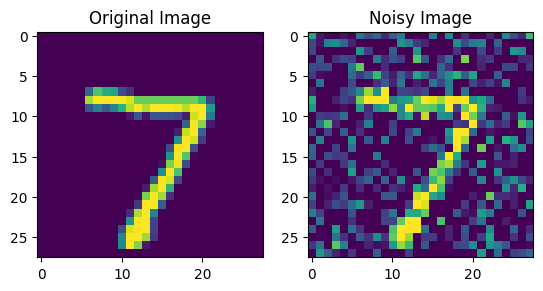

In [18]:
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(test_images[0].reshape(28, 28))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_test_images[0].reshape(28, 28))
plt.title('Noisy Image')

plt.show()

### Classifying noisy reconstructions of SAE and DAE with Linear SVC

In [14]:
noisy_reconstructions = []
model.eval()

for image in noisy_test_images:
    image = torch.tensor(image).float().to('cuda')
    input = image.view(1, -1).to('cuda')
    encoded, decoded = model(input)
    noisy_reconstructions.append(decoded.cpu().detach().numpy())

noisy_reconstructions = np.concatenate(noisy_reconstructions, axis=0)

In [15]:
noisy_dev_reconstructions = []
dev_model.eval()

for image in noisy_test_images:
    image = torch.tensor(image).float().to('cpu')
    input = image.view(1, -1).to('cpu')
    encoded, decoded = dev_model(input)
    noisy_dev_reconstructions.append(decoded.cpu().detach().numpy())

noisy_dev_reconstructions = np.concatenate(noisy_dev_reconstructions, axis=0)

In [16]:
noisy_ae_predictions = svc.predict(noisy_reconstructions)
accuracy = accuracy_score(noisy_ae_predictions, test_labels)
print(f'AE Test Accuracy: {accuracy:.4f}')

noisy_dae_predictions = svc.predict(noisy_dev_reconstructions)
accuracy = accuracy_score(noisy_dae_predictions, test_labels)
print(f'DAE Test Accuracy: {accuracy:.4f}')

AE Test Accuracy: 0.7259
DAE Test Accuracy: 0.0892
